# Pairs Trading Implementation

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

import sys
sys.path.append('./src/')
from random_walk_forcast import *

In [7]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})

In [8]:
pairs = pd.read_csv('data/pairs_bundle.csv', index_col=0)
pairs.index = pd.to_datetime(pairs.index)

In [9]:
pairs.columns

Index(['CVX', 'CVX/XOM', 'KO', 'PEP', 'PEP/KO', 'T', 'VZ', 'VZ/T', 'XOM'], dtype='object')

In [10]:
pairs.head()

,CVX,CVX/XOM,KO,PEP,PEP/KO,T,VZ,VZ/T,XOM
Date,,,,,,,,,
1990-01-02,6.724925,0.864271,2.791292,6.310486,2.260776,6.506971,12.543602,1.927718,7.781034
1990-01-03,6.622892,0.859756,2.753444,6.249591,2.269736,6.393413,12.516094,1.957655,7.703223
1990-01-04,6.530134,0.856365,2.743982,6.187714,2.255012,6.272066,12.061367,1.923029,7.625413
1990-01-05,6.437377,0.848530,2.715596,6.102264,2.247118,5.969798,11.785666,1.974215,7.586508
1990-01-08,6.502307,0.844102,2.772368,6.212268,2.240780,6.070554,11.882713,1.957435,7.703223


In [11]:
def plot_pair(series1, series2, names):
    """
    Plot pair series with name subsitutions
    """
    
    fig, ax = plt.subplots(figsize=(20,8));
    years = YearLocator();
    yearsFmt = DateFormatter('%Y');
    
    ax.xaxis.set_major_locator(years);
    ax.xaxis.set_major_formatter(yearsFmt);
    ax.autoscale_view();
    
    index = series1.index
    
    plt.title(names[0] + ' and ' + 
              names[1] +' (Adj. Close)', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    ax.plot_date(index, series1, 'indianred', label=names[0]);
    ax.plot_date(index, series2, 'steelblue', label=names[1]);
 
    plt.legend(loc=2, prop={'size':15}, frameon=True);

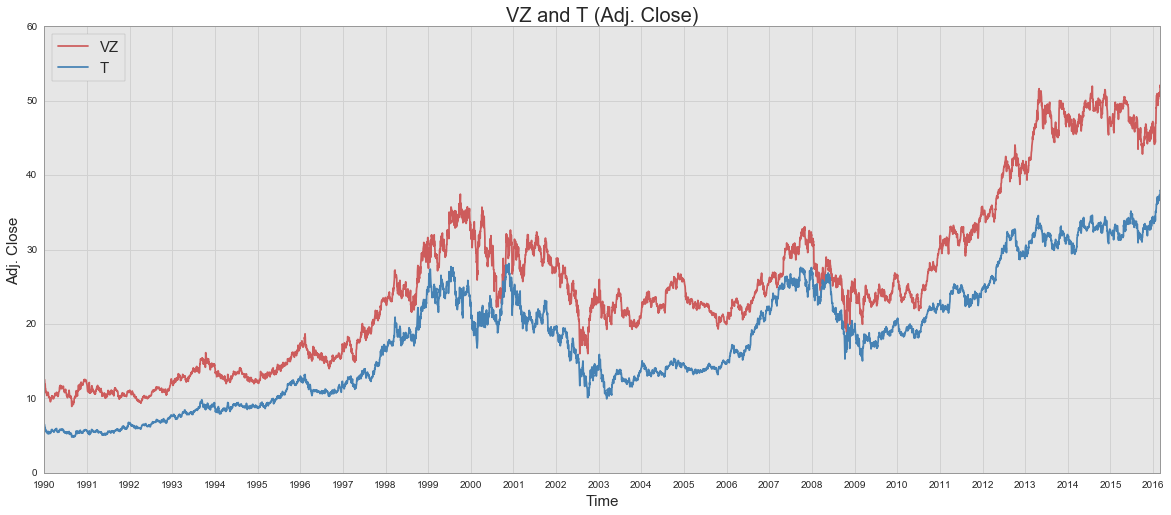

In [42]:
plot_pair(pairs['VZ'], pairs['T'], ['VZ','T'])

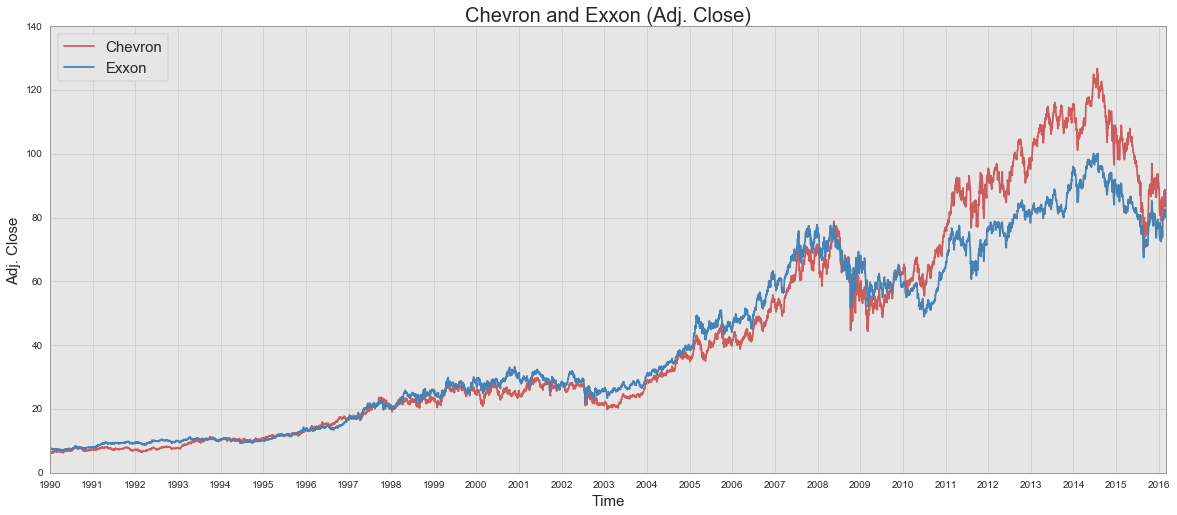

In [40]:
plot_pair(pairs.CVX, pairs.XOM, ['Chevron','Exxon'])

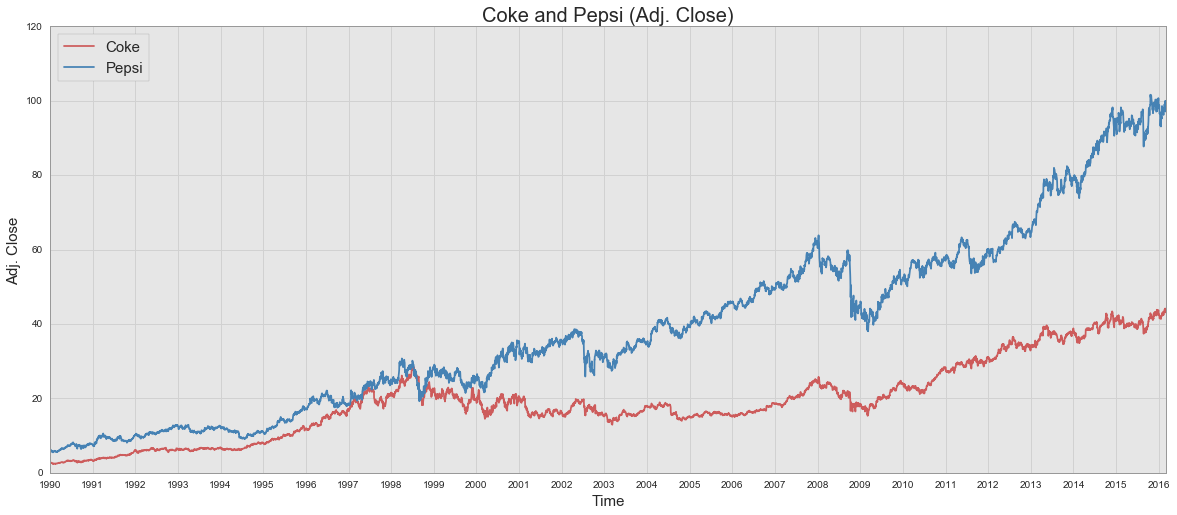

In [13]:
plot_pair(pairs.KO, pairs.PEP, ['Coke','Pepsi'])

In [14]:
def plot_ratio(ratio, name, deviations=[1], positions=[]):
    fig = plt.subplots(figsize=(20,8));

    plt.title('Ratio ' + name + ' Adjusted Close', fontsize=20);
    plt.ylabel('Ratio', fontsize=15);
    plt.xlabel('Time Index', fontsize=15);
    plt.xlim([0,ratio.size])
    plt.xticks(np.arange(0, ratio.size, 500))
    
    plt.plot(np.arange(ratio.size), ratio, 'black', label='$Ratio$', alpha=0.5);
    plt.plot([0, ratio.size], [ratio.mean(), ratio.mean()], 'steelblue', lw=2, label=r'$\hat{\mu}$');
    
    for color, std in zip(['y','orange','salmon','red'], deviations):
        latex_prep = '$' + str(std) + '$'
        plt.plot([0, ratio.size], [ratio.mean()-std*ratio.std(), ratio.mean()-std*ratio.std()], 
                 '--', lw=2, label='$\hat{\mu} \pm$' + latex_prep + '$\hat{\sigma}$', color=color);
        plt.plot([0, ratio.size], [ratio.mean()+std*ratio.std(), ratio.mean()+std*ratio.std()], 
                 '--', lw=2, color=color);
    
    if positions:
        opening_days, closing_days = [], []
        opening_ratios, closing_ratios = [], []
        
        for position in positions:
            if 'open' in position.keys():
                opening_days.append(position['open'])
                opening_ratios.append(ratio.ix[position['open']])
            if 'close' in position.keys():
                closing_days.append(position['close'])
                closing_ratios.append(ratio.ix[position['close']])
            
        plt.scatter(x=opening_days, y=opening_ratios, s=150, color='lime', edgecolor='black', label='$Open$ '+'$Position$')
        plt.scatter(x=closing_days, y=closing_ratios, s=150, color='red', edgecolor='black', label='$Close$ '+'$Position$')
    
    plt.legend(loc='best', prop={'size':15}, frameon=True);

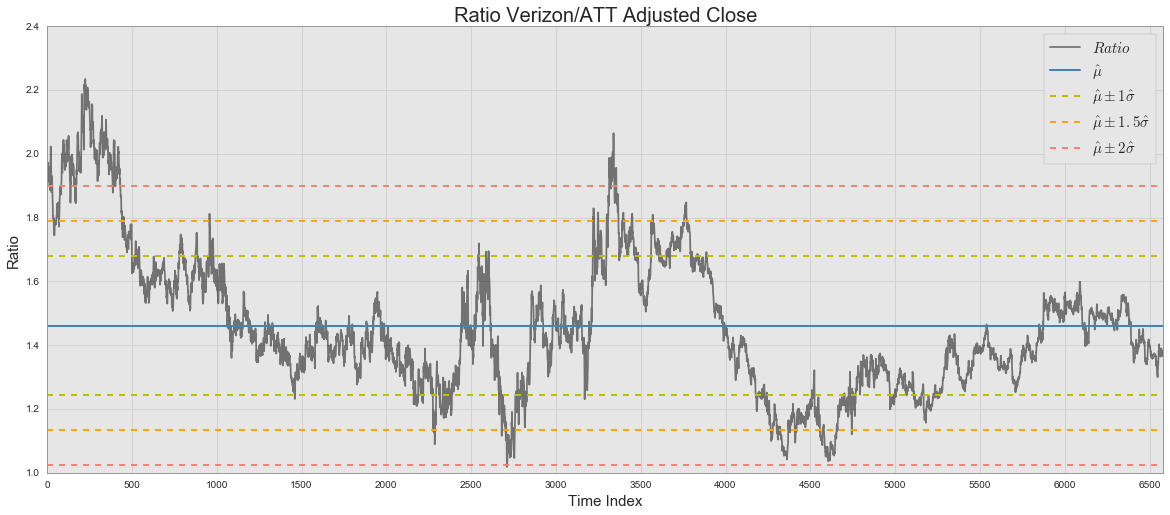

In [15]:
plot_ratio(pairs['VZ/T'], name='Verizon/ATT', deviations=[1,1.5,2])

In [16]:
# plot_ratio(pairs['PEP/KO'], name='Coke/Pepsi', deviations=[1,1.5,2])

In [17]:
def identify_next_position(ratio, k, start=0):
    result = {}
    mean, sd = ratio.mean(), ratio.std()
    day, size = start, ratio.size
    
    while day < size:
        
        if ratio.ix[day] > mean + k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] <= mean:
                    result['close'] = day
                    return result
                day += 1
        
        elif ratio.ix[day] < mean - k*sd:
            result['open'] = day
            day += 1
            
            while day < size:
                if ratio.ix[day] >= mean:
                    result['close'] = day
                    return result
                day += 1
                
        day += 1
        
    return result

In [18]:
# identify_next_position(cell['VZ/T'], 1)

In [19]:
# plot_ratio(cell['VZ/T'], 'Verizon/ATT', deviations=[1,2], positions=[identify_next_position(cell['VZ/T'], 1, 1171)])

In [20]:
def identify_all_positions(ratio, k, start=0):
    positions = []
    day, size = start, ratio.size
    
    while day < size:
        position = identify_next_position(ratio, k, day)
        if 'close' in position.keys():
            positions.append(position)
            day = position['close']
        else:
            if 'open' in position.keys():
                position['close'] = size-1
                positions.append(position)
            break
    
    return positions

In [21]:
identify_all_positions(pairs['PEP/KO'], 1)

[{'close': 421, 'open': 284},
 {'close': 2836, 'open': 1137},
 {'close': 5334, 'open': 3708}]

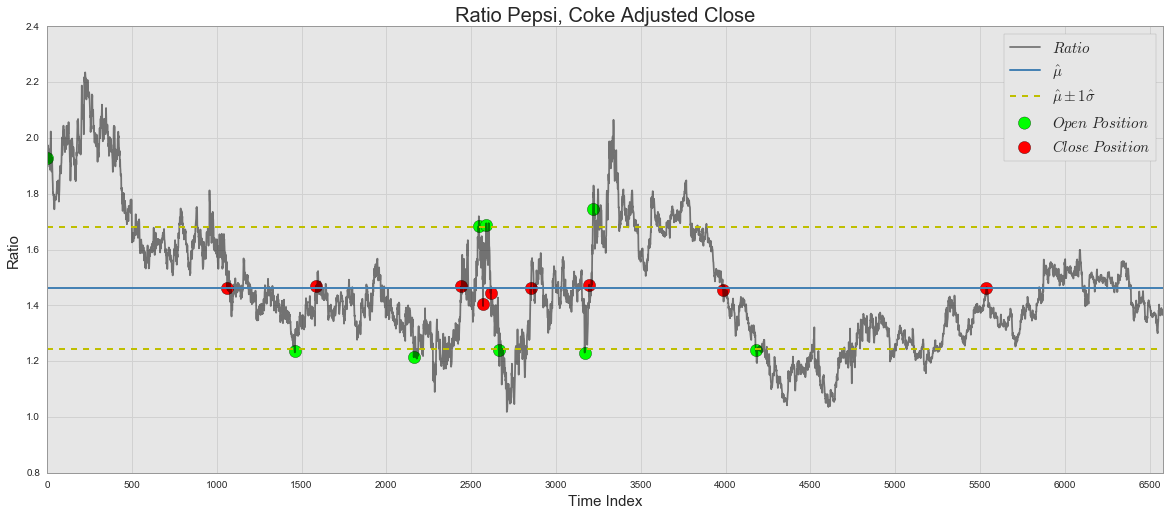

In [43]:
positions = identify_all_positions(pairs['VZ/T'], 1)
plot_ratio(pairs['VZ/T'], 'Pepsi, Coke', deviations=[1], positions=positions)

In [23]:
1 + ((200)*0.00192197)

1.384394

In [24]:
get_expected_walk(pairs['PEP/KO'][:3708], 3708-2836, 1)[1]

array([ 0.00192197])

In [25]:
# plot_expected_forcast(pairs['PEP/KO'], 3708-2836, 50, 3708)

In [26]:
# plot_expected_forcast(pairs['PEP/KO'], 1137-421, 50, 1137)

In [27]:
# positions

In [44]:
def trade(numer_prices, denom_prices, ratio, positions, swap_count=1):
    
    #cur_portfolio_value = numer_prices.ix[0]*numer_shares + denom_prices.ix[0]*denom_shares
    cur_portfolio_value = 0
    init_portfolio_value = 0
    
    for position in positions:
        if ratio.ix[position['open']] > ratio.mean():
            cur_portfolio_value += swap_count*numer_prices.ix[position['open']]
            cur_portfolio_value -= swap_count*denom_prices.ix[position['open']]
            cur_portfolio_value -= swap_count*numer_prices.ix[position['close']]
            cur_portfolio_value += swap_count*denom_prices.ix[position['close']]
        elif ratio.ix[position['open']] < ratio.mean():
            cur_portfolio_value -= swap_count*numer_prices.ix[position['open']]
            cur_portfolio_value += swap_count*denom_prices.ix[position['open']]
            cur_portfolio_value += swap_count*numer_prices.ix[position['close']]
            cur_portfolio_value -= swap_count*denom_prices.ix[position['close']]
    
    return {#'init_portfolio_value': init_portfolio_value,
            'end_portfolio_value': cur_portfolio_value,
            'net_gain': cur_portfolio_value - init_portfolio_value,
            'net_gain/year': (cur_portfolio_value - init_portfolio_value) / (ratio.count() / 252) } 
            # 252 trade days / year

In [46]:
trade(pairs['VZ'], pairs['T'], pairs['VZ/T'], positions, 100)

{'end_portfolio_value': 3425.1488185166436,
 'net_gain': 3425.1488185166436,
 'net_gain/year': 131.17591219850976}

In [49]:
# trade(pairs['CVX'], 10000, pairs['XOM'], 10000, pairs['CVX/XOM'], positions, 2000)

In [112]:
# from statsmodels.tsa import *
# from scipy.optimize import brute

In [113]:
# def acf_objective(order, series):
#     try:
#         model = arima_model.ARIMA(series, order).fit(method="newton")
#         return model.aic
#     except:
#         return np.inf # if the model is not stationary return inf

In [114]:
# def get_optimal_arima(series, cost):
  
#     grid = (slice(1, 4, 1), slice(1,2,1), slice(1, 4, 1))
#     orders = brute(cost, grid, args=(series,), finish=None)
#     orders = [int(order) for order in orders]
  
#     arima = arima_model.ARIMA(series, order=orders).fit()
#     print({'p':orders[0], 'd':orders[1], 'q':orders[2]})
  
#     return arima

In [115]:
# def fit_arima(series, p, d, q):
#     model = arima_model.ARIMA(series, [p,d,q], method='css').fit()
#     return model.aic

In [116]:
# arima = get_optimal_arima(pairs['CVX/XOM'], acf_objective)

In [117]:
# fig, ax = plt.subplots(figsize=(15,6))
# ax.plot(np.arange(1,len(pairs['CVX/XOM'])+1), pairs['CVX/XOM'])
# fig = arima.plot_predict(len(pairs['CVX/XOM'])-1, len(pairs['CVX/XOM'])+500, dynamic=True, ax=ax,
#                          plot_insample=False)

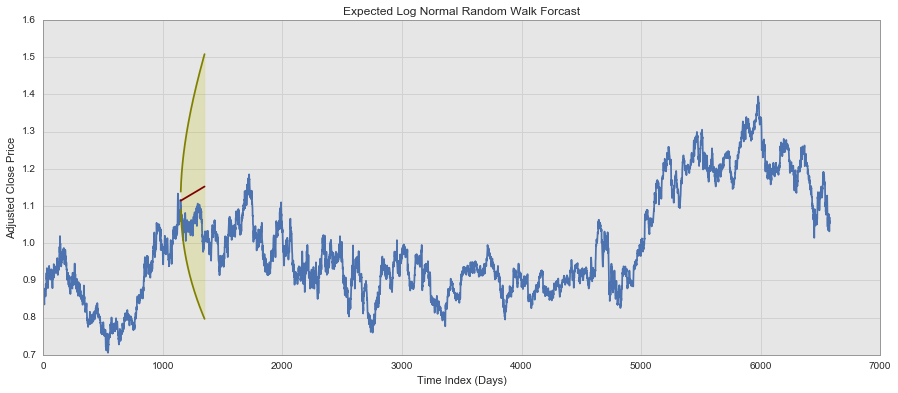

In [51]:
plot_expected_forcast(pairs['CVX/XOM'], 500, 200, 1150)}

#### TODO
* off more shares as becomes more extreme
* dont off same shares everytime
* maybe close potentially open position
* real time updates (cron job)